In [1]:
import torch
import torchvision
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score

In [2]:
dataset = torchvision.datasets.EMNIST(root="./data", split="letters", train=True, download=True)
test_dataset = torchvision.datasets.EMNIST(root="./data", split="letters", train=False, download=True)

x_train = dataset.data.numpy()
y_train = dataset.targets.numpy()
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

print(x_train.shape)
print(y_train.shape)


100%|██████████| 562M/562M [00:46<00:00, 12.2MB/s] 


(124800, 28, 28)
(124800,)


In [3]:
print("x_train shape:", x_train.shape)  # Should be (num_samples, 28, 28, 1)
print("y_train shape:", y_train.shape)  # Check if it's one-hot encoded or not


x_train shape: (124800, 28, 28)
y_train shape: (124800,)


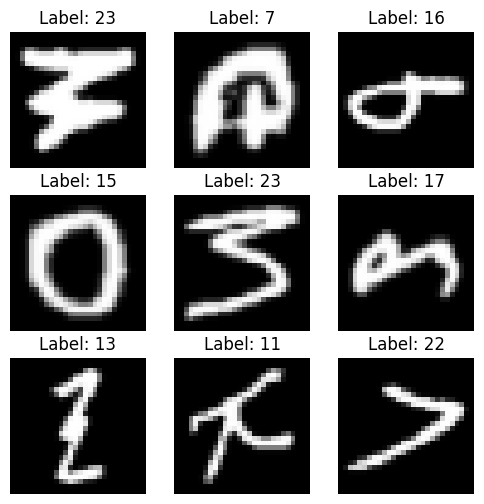

In [4]:
def plot_images(images, labels, num_images=9):
    plt.figure(figsize=(6,6))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

plot_images(x_train[:20], y_train[:20])
#1.a DONE

In [5]:
from tensorflow.keras.utils import to_categorical
x_train = x_train.astype("float32") / 255.0  # Normalize to [0, 1]
x_train = np.expand_dims(x_train, axis=-1)  # Add the channel dimension
x_test = x_test.astype("float32") / 255.0  # Normalize to [0, 1]
x_test = np.expand_dims(x_test, axis=-1)
y_train=to_categorical(y_train-1,num_classes=26)
y_test=to_categorical(y_test-1,num_classes=26)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Training Fold 1
Fold 1 - Validation Accuracy: 3.49%
Fold 1 - Test Set Accuracy: 3.73%
Epoch 1/15
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5950 - loss: 1.5392 - val_accuracy: 0.7791 - val_loss: 0.7743
Epoch 2/15
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8012 - loss: 0.6897 - val_accuracy: 0.8332 - val_loss: 0.5746
Epoch 3/15
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8446 - loss: 0.5279 - val_accuracy: 0.8547 - val_loss: 0.4899
Epoch 4/15
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8714 - loss: 0.4314 - val_accuracy: 0.8713 - val_loss: 0.4367
Epoch 5/15
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8835 - loss: 0.3869 - val_accuracy: 0.8759 - val_loss: 0.4115
Epoch 6/15
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8931 - loss: 0.3510 - val_accuracy: 0.8800 - val_loss: 0.3935
Epoch 7/15
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9009 - loss: 0.3203 - val_accuracy: 0.8823 - val_loss: 0.3837

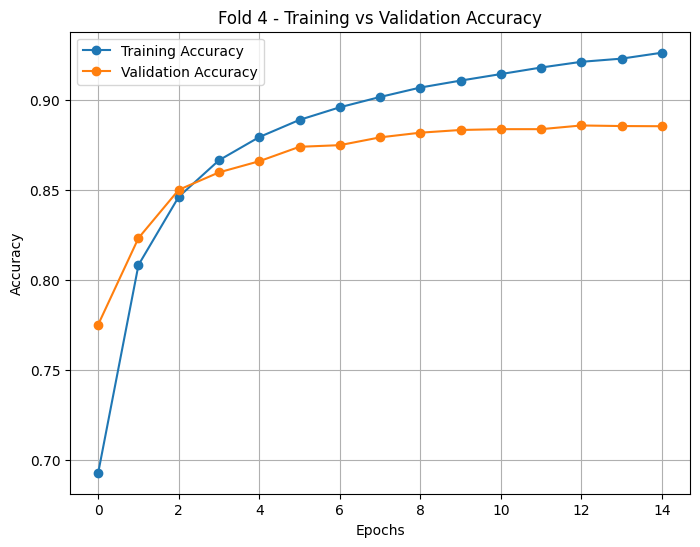

In [18]:
#14.using the sigmoid activation instead of relu
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

cv=KFold(n_splits=4,shuffle=True,random_state=42)
accuracy=[]
# Loop through each fold for training and validation
for fold, (train_, test_) in enumerate(cv.split(x_train)):
    print(f"Training Fold {fold + 1}")

    # Split data into training and validation sets
    x_train_fold, x_val_fold = x_train[train_], x_train[test_]
    y_train_fold, y_val_fold = y_train[train_], y_train[test_]

    # Build the model
    ann = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation='sigmoid'),
        layers.Dense(26, activation='softmax')
    ])
    ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model

    # Evaluate the model on the validation fold
    loss_, acc_ = ann.evaluate(x_val_fold, y_val_fold, verbose=0)
    accuracy.append(acc_)

    # Optionally, evaluate on the test set
    test_loss, test_accuracy = ann.evaluate(x_test, y_test, verbose=0)
    print(f"Fold {fold + 1} - Validation Accuracy: {acc_ * 100:.2f}%")
    print(f"Fold {fold + 1} - Test Set Accuracy: {test_accuracy * 100:.2f}%")
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    history = ann.fit(x_train_fold, y_train_fold, batch_size=30, epochs=15, validation_data=(x_val_fold, y_val_fold),callbacks=[early_stopping], verbose=1)

# Plot accuracy per epoch for this fold
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Fold {fold+1} - Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Training Fold 1


c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold 1 - Validation Accuracy: 3.81%
Fold 1 - Test Set Accuracy: 4.24%
Epoch 1/15
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6764 - loss: 1.1124 - val_accuracy: 0.8471 - val_loss: 0.4920
Epoch 2/15
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8666 - loss: 0.4274 - val_accuracy: 0.8744 - val_loss: 0.3987
Epoch 3/15
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8916 - loss: 0.3431 - val_accuracy: 0.8833 - val_loss: 0.3727
Epoch 4/15
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9038 - loss: 0.2972 - val_accuracy: 0.8863 - val_loss: 0.3659
Epoch 5/15
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9100 - loss: 0.2733 - val_accuracy: 0.8891 - val_loss: 0.3566
Epoch 6/15
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9163 - loss: 0.2500 - val_accuracy: 0.8872 - val_loss: 0.3592
Epoch 7/15
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9206 - loss: 0.2340 - val_accuracy: 0.8939 - val_loss: 0.3492
Epoch 8/15
3328/332

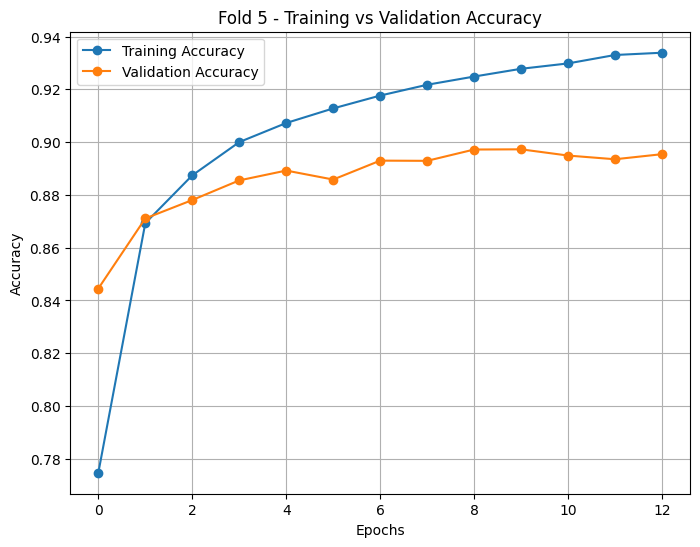

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

cv=KFold(n_splits=4,shuffle=True,random_state=42)
accuracy=[]
# Loop through each fold for training and validation
for fold, (train_, test_) in enumerate(cv.split(x_train)):
    print(f"Training Fold {fold + 1}")

    # Split data into training and validation sets
    x_train_fold, x_val_fold = x_train[train_], x_train[test_]
    y_train_fold, y_val_fold = y_train[train_], y_train[test_]

    # Build the model
    ann = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(26, activation='softmax')
    ])
    ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model

    # Evaluate the model on the validation fold
    loss_, acc_ = ann.evaluate(x_val_fold, y_val_fold, verbose=0)
    accuracy.append(acc_)

    # Optionally, evaluate on the test set
    test_loss, test_accuracy = ann.evaluate(x_test, y_test, verbose=0)
    print(f"Fold {fold + 1} - Validation Accuracy: {acc_ * 100:.2f}%")
    print(f"Fold {fold + 1} - Test Set Accuracy: {test_accuracy * 100:.2f}%")
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    history = ann.fit(x_train_fold, y_train_fold, batch_size=30, epochs=15, validation_data=(x_val_fold, y_val_fold),callbacks=[early_stopping], verbose=1)

# Plot accuracy per epoch for this fold
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Fold {fold+1} - Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
loss_,acc_=ann.evaluate(x_val_fold,y_val_fold,verbose=0)
accuracy.append(acc_)
test_loss, test_accuracy = ann.evaluate(x_test, y_test, verbose=0)
print(f"Fold {fold + 1} Accuracy: {acc_ * 100:.2f}%")
print(f"Test Set Accuracy: {test_accuracy * 100:.2f}%")

Fold 5 Accuracy: 89.73%
Test Set Accuracy: 89.83%


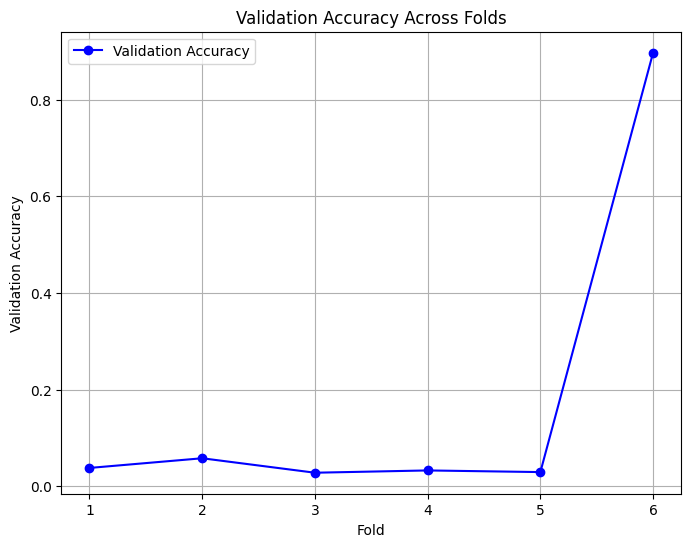

In [8]:
# Visualize the performance across folds
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(accuracy) + 1), accuracy, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.title('Validation Accuracy Across Folds')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy') 
plt.xticks(range(1, len(accuracy) + 1))
plt.grid(True)
plt.legend()
plt.show()

In [9]:
#confusion matrix
ypred=ann.predict(x_test)
ypred
y_pred_classes = np.argmax(ypred, axis=1)  # Convert to class labels
y_pred_classes

y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels back to class labels
y_true

650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([ 0,  0,  0, ..., 25, 25, 25])

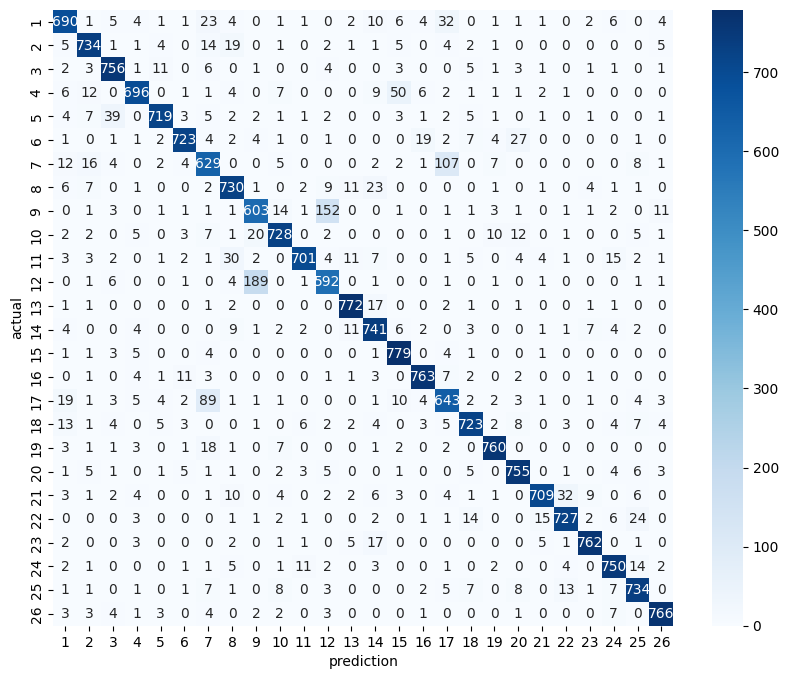

In [10]:
import seaborn as sns

cm=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 27), yticklabels=range(1, 27))
plt.xlabel("prediction")
plt.ylabel("actual")
plt.show()


In [11]:
print(classification_report(y_true, y_pred_classes, digits=4))


              precision    recall  f1-score   support

           0     0.8801    0.8625    0.8712       800
           1     0.9129    0.9175    0.9152       800
           2     0.9054    0.9450    0.9248       800
           3     0.9380    0.8700    0.9027       800
           4     0.9523    0.8988    0.9248       800
           5     0.9476    0.9038    0.9251       800
           6     0.7652    0.7863    0.7756       800
           7     0.8795    0.9125    0.8957       800
           8     0.7283    0.7538    0.7408       800
           9     0.9239    0.9100    0.9169       800
          10     0.9590    0.8762    0.9157       800
          11     0.7532    0.7400    0.7465       800
          12     0.9438    0.9650    0.9543       800
          13     0.8728    0.9263    0.8987       800
          14     0.8944    0.9738    0.9324       800
          15     0.9455    0.9537    0.9496       800
          16     0.7775    0.8037    0.7904       800
          17     0.9210    

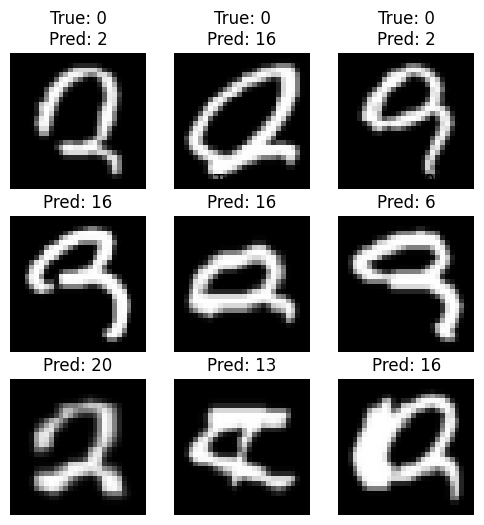

In [12]:
#11 Visualize misclassified images show incorrectly predicted images with actual vs predicted labels.
misclassified=np.where(y_pred_classes !=y_true)[0]
def plot_misclassified(images, true_labels, pred_labels, indices, num_images=9):
    plt.figure(figsize=(6, 6))
    for i in range(min(num_images, len(indices))):
        idx = indices[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx], cmap="gray")
        plt.title(f"True: {true_labels[idx]}\nPred: {pred_labels[idx]}")
        plt.axis("off")
    plt.show()
plot_misclassified(x_test, y_true, y_pred_classes, misclassified)


In [13]:
#12 most misclassified is "i"and mostly with "l" as shown in the confusion matrix

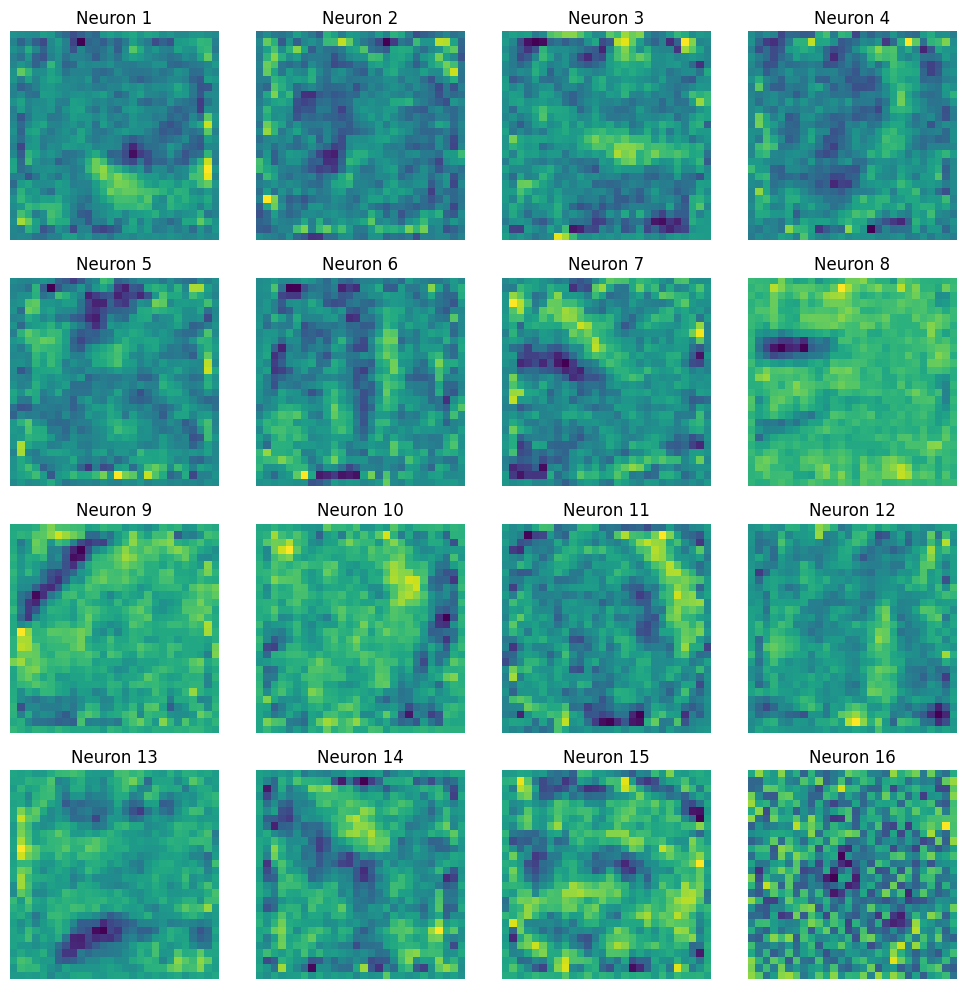

In [14]:
hidden_layer_weights = ann.layers[1].get_weights()[0]  # Get weights (ignore biases)

# Normalize for better visualization
hidden_layer_weights = (hidden_layer_weights - np.min(hidden_layer_weights)) / (np.max(hidden_layer_weights) - np.min(hidden_layer_weights))

# Select first 16 neurons for visualization
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(hidden_layer_weights[:, i].reshape(28, 28), cmap='viridis')
    ax.axis('off')
    ax.set_title(f"Neuron {i+1}")

plt.tight_layout()
plt.show()

In [15]:
##13.b Early layers in neural networks detect basic patterns like edges, curves, and textures.
#If the weights look like edges, blobs, or strokes, the model is learning basic shapes to distinguish letters.

In [ ]:
#14 the EMINST datset by default has only lowercased(the one im using) and i was having a problem using the one with both lower and upper case so i used this one

In [ ]:
#17 the report will be included in the document

In [ ]:
#The results of this project demonstrated that different architectural choices,
#  including activation functions, the number of hidden layers, and batch size, had minimal impact on overall accuracy.
#  Both ReLU and Sigmoid activations produced similar classification performance, with Sigmoid leading to smoother training curves.
#  Increasing the number of hidden layers did not significantly improve accuracy, indicating that a simpler architecture is sufficient for the EMNIST dataset.

#Tuning the batch size revealed a trade-off between stability and training speed,
#  where smaller batches improved generalization but increased training time.
#  Additionally, cross-validation was useful in evaluating model robustness, but it significantly increased computational time.